In [1]:
SEED = 42
from numpy.random import seed
from tensorflow.random import set_seed
seed(SEED)
set_seed(SEED)

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import nltk
from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1 Dataset 

Dataset: tiny shakespeare dataset 
- 40000 lines of shakespeare text

Steps:
- Download
- Convert to numpy array

In [2]:
train_data = tfds.load(name='tiny_shakespeare')['train']                    

In [3]:
text_ds = []
for e in train_data:
  text_ds.append(e['text'])

#Convert string tensor to byte object to string array
text_data = str(text_ds[0].numpy(),'utf-8')

# 2 Word Embeddings

**2.1) Preprocessing**
Steps:
 - Filter most common 10.000 words
 - Assign IDs to each of the 10.000 words
 - Create a dictionary for translation ID <> word
 - Create input-target pairs [ input word w, context window 4, 3 pairs { (w, context_word1), (w, context_word2), (w, context_word3) } ]
 - [OUTSTANDING]: Subsampling according to probability formula

###Line Seperation and normalization

In [4]:
lines = text_data.split(sep = '\n')
print("Count of lines: " + str(len(lines)))

Count of lines: 35526


In [5]:
def normalize_line(line):

  #delete non Alphabetical inputs
  match1 = re.compile('[^a-zA-Z ]')
  line = match1.sub("",line)

  #lowercasing
  line = line.lower()

  #

  return line

###Tokenization

In [6]:
tokens=[]
for line in lines:
  line = normalize_line(line)
  tokens += nltk.tokenize.word_tokenize(line)

###Identifying most commen 1000

In [7]:
fdist = FreqDist(tokens)
mostcommon = fdist.most_common(n=10000)

###WordToId and IdToWord

In [8]:
#dictionary for ID <> most common words translation
WordToId = {}
IdToWord = {}

for i in range (10000):
  WordToId.update({mostcommon[i][0]:i+1})
  IdToWord.update({i+1:mostcommon[i][0]})

###Only keep 10000 words in text.

In [9]:
#filtering the text, so that only the tokens, which are in the top1000 of tokens stay in the text.
text_10000 = []
for token in tokens:
  if(token in WordToId.keys()):
    text_10000.append(token)


###Identifying context

In [10]:
#context window size
window_size = 1 #in every direction from the starting target word
contexts=ngrams(text_10000, window_size*2+1)


input_output = []
inputs=[]
input_target_dict={}
for context in contexts:
  #word is exactly the mode of the context vector
  input = context[window_size]
  inputs+=[input]


  #das geht bestimmt hübscher...:D
  #In case the input has not yet been detected
  try:
    input_target_dict[input]+=list(context[:window_size:])
    #deleting double entries
    #input_target_dict[input]=list(set(input_target_dict[input]))
  except KeyError:
    input_target_dict[input]=list(context[:window_size:])
    #deleting double entries
    #input_target_dict[input]=list(set(input_target_dict[input]))
  

In [11]:
count=0
for key in input_target_dict.keys():
  print(key,":",input_target_dict[key])
  count+=1
  if count==5:
    break

citizen : ['first', 'first', 'first', 'first', 'second', 'first', 'second', 'second', 'first', 'second', 'first', 'second', 'first', 'first', 'second', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'second', 'third', 'first', 'third', 'second', 'third', 'second', 'third', 'second', 'third', 'third', 'second', 'third', 'third', 'first', 'second', 'third', 'second', 'fourth', 'fourth', 'fifth', 'fourth', 'sixth', 'seventh', 'first', 'second', 'third', 'first', 'second', 'third', 'third', 'second', 'first', 'first', 'a', 'sir', 'antium', 'you', 'first', 'first', 'second', 'third', 'first', 'second', 'first', 'second', 'first', 'second', 'third', 'first', 'third', 'second', 'third', 'first', 'third', 'second', 'first', 'third', 'first', 'third', 'first', 'third', 'second', 'third', 'second', 'third', 'a', 'first', 'first', 'first']
before : ['citizen', 'down', 'down', 'shields', 'dined', 'forth', 'did'

##Subsampling


Formula for Subsampling:
 $P(w_i) = (\sqrt{\frac{z(w_i)}{s}} + 1) \cdot \frac{s}{z(w_i)}$

$P(w_i)$: probability for keeping a word (sample rate)

$w_i$: the i-th word

$z(w_i)$: fraction of the total words being $w_i$

$s$: hyperparameter (we set $s=0.001$)

In [12]:
def subsampling(fraction,min,max, s = 0.001):
  prob = (np.sqrt(fraction / s) + 1 ) * (s / fraction) 
  
  prob = (prob-min)/(max-min)
  #result = {0 = discard word, 1 = keep word}
  #print(prob)
  #ERROR: prob > 1 or < 0
  result = np.random.binomial(n = 1, p = prob)
  #keep word?
  #return (1 == 1)
  return (result == 1)

In [13]:
word_count=0
for key in input_target_dict.keys():
  word_count+=len(input_target_dict[key])

In [14]:
input_output=[]
for input in input_target_dict.keys():
  for target in input_target_dict[input]:
    input_output+=[(input, target)]
print(len(input_output))

180574


In [15]:
s= 0.001

min=(np.sqrt((mostcommon[0][1]/ word_count)/ s) + 1 ) * (s / (mostcommon[0][1]/ word_count))

max=(np.sqrt((mostcommon[-1][1]/ word_count)/ s) + 1 ) * (s / (mostcommon[-1][1]/ word_count)) 
    
print(min)
print(max)

for input in input_target_dict.keys():
  for target in input_target_dict[input]:
    

    fraction = fdist[target] / word_count
    #print(target)
    #print(fraction)
    keep_word = subsampling(fraction,min, max,s)
    if not(keep_word):
      input_target_dict[input].remove(target)


0.2092873315900598
194.01178255516885


In [16]:
input_output=[]
for input in input_target_dict.keys():
  for target in input_target_dict[input]:
    input_output+=[(input, target)]
print(len(input_output))

90267


In [17]:
print(input_output[:30])

[('citizen', 'first'), ('citizen', 'first'), ('citizen', 'first'), ('citizen', 'first'), ('citizen', 'first'), ('citizen', 'fifth'), ('citizen', 'fourth'), ('citizen', 'sixth'), ('citizen', 'seventh'), ('citizen', 'first'), ('citizen', 'second'), ('citizen', 'first'), ('citizen', 'second'), ('citizen', 'third'), ('citizen', 'second'), ('citizen', 'first'), ('citizen', 'first'), ('citizen', 'sir'), ('citizen', 'antium'), ('citizen', 'first'), ('citizen', 'first'), ('citizen', 'second'), ('citizen', 'third'), ('citizen', 'first'), ('citizen', 'second'), ('citizen', 'first'), ('citizen', 'second'), ('citizen', 'first'), ('citizen', 'second'), ('citizen', 'third')]


In [18]:
input_list=[WordToId[x] for (x,y) in input_output]
target_list=[WordToId[y] for (x,y) in input_output]

input_tensor=tf.data.Dataset.from_tensor_slices(input_list)
target_tensor=tf.data.Dataset.from_tensor_slices(target_list)

#One Hot Encode 

In [19]:
for i in input_tensor.take(10):
  print(i)

tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)
tf.Tensor(246, shape=(), dtype=int32)


In [20]:
input_tensor=input_tensor.map(lambda input:tf.one_hot(input,10000))
target_tensor=target_tensor.map(lambda target:tf.transpose(tf.one_hot(target,10000)))


In [21]:
for i in input_tensor.take(10):
  print(i)
  print(tf.argmax(i))

tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)
tf.Tensor(246, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32

In [22]:


train_ds=tf.data.Dataset.zip((input_tensor,target_tensor))

###Batching and Shuffling

In [23]:
train_ds = train_ds.batch(64)
train_ds = train_ds.shuffle(buffer_size = 64)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

#2.2 Building the Model

In [24]:
tf.random.uniform([1], 1, 10000, dtype = tf.dtypes.int32).numpy()

array([4140], dtype=int32)

In [25]:
class encoder(tf.keras.layers.Layer):
  def __init__(self, h=64):
      super(encoder, self).__init__()
      self.h=h
      

  def build(self, input_shape):  # Create the state of the layer (weights)
    self.w = self.add_weight(
            shape=(input_shape[-1], self.h),
            initializer="random_normal",
            trainable=True,
        )
  def call(self, inputs, targets):  # Defines the computation from inputs to outputs
      #print(self.w.shape)
      #print(inputs.shape)
      #print(tf.argmax(inputs))
      embeddings = tf.nn.embedding_lookup(self.w, tf.argmax(inputs, axis = 1))
      embed_size = self.w.shape[-1]
      vocab_size = self.w.shape[-2]
      #print(embed_size)
      #print(vocab_size)
      
      labels = tf.reshape(tf.argmax(targets,1), [-1,1])
      #loss for SGD
      #print(labels.shape)
      loss = tf.reduce_mean(
          tf.nn.sampled_softmax_loss(
              weights = self.w,
              biases = tf.Variable(tf.zeros([embed_size])),
              labels = labels,
              inputs = embeddings,
              #num of randomly sampled negative samples
              num_sampled = 1000,
              num_classes = vocab_size
          )
      )
      #score for accuracy
      output_score = tf.matmul(embeddings, tf.transpose(self.w))
      return loss, output_score

In [26]:
class decoder(tf.keras.layers.Layer):
  def __init__(self, V=10000):
      super(decoder, self).__init__()
      self.V=V
      

  def build(self, input_shape):  # Create the state of the layer (weights)
    self.w = self.add_weight(
            shape=(input_shape[-1], self.V),
            initializer="random_normal",
            trainable=True,
        )

  def call(self, inputs):  # Defines the computation from inputs to outputs
      #print(self.w.shape)
      x = tf.matmul(inputs, self.w)
      x = tf.keras.activations.softmax(x)
      #print(x.shape)
      return x

In [27]:
class Model(tf.keras.Model):
  def __init__(self, V=10000):
      super(Model, self).__init__()
      self.encoder = encoder(h=64)
      self.decoder = decoder(V=V)

  def call(self, inputs, targets):  # Defines the computation from inputs to outputs
      loss, output_score = self.encoder(inputs, targets)
      #x = self.decoder(x)
      return loss, output_score

In [28]:
model = Model()
#encoder = encoder()
#decoder = decoder()
for (input, target) in train_ds.take(5):
  #print(input.shape)
  #print(target.shape)
  #print(encoder(input).shape)
  #print(np.sum(test_dec(input), axis = -1))
  #print(tf.argmax(input, axis = 1))
  #print(tf.argmax(target, axis = 1))
  loss, output_score = model(input, target)
  print(loss)
  print(output_score.shape)
  print(tf.argmax(output_score, axis = 1))

tf.Tensor(8.344749, shape=(), dtype=float32)
(64, 10000)
tf.Tensor(
[41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41], shape=(64,), dtype=int64)
tf.Tensor(8.812876, shape=(), dtype=float32)
(64, 10000)
tf.Tensor(
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7], shape=(64,), dtype=int64)
tf.Tensor(8.904131, shape=(), dtype=float32)
(64, 10000)
tf.Tensor(
[107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107
 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107
 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107 107  35  35
  35  35  35  35  35  35  35  35  35  35], shape=(64,), dtype=int64)
tf.Tensor(8.695111, shape=(), dtype=float32)
(64, 10000)
tf.Tensor(
[41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 4

# 2.3) Training

In [29]:
#General Parameters
trainforNepochs=20                                      
learning_rate=0.01                                       
running_average_factor = 0.95                           
#lossfunction= tf.keras.losses.CategoricalCrossentropy() #we use categorical cross entropy as lossfunction
optimizer = tf.keras.optimizers.Adam(learning_rate)      #we use SGD as optimizer

model = Model()

In [30]:
def train_step(model, input, target, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    loss, _ = model(input, target)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [31]:
def test(model, test_data):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    loss, output_score = model(input, target)
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(output_score, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [32]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
train_accuracies = []

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, train_accuracy = test(model, train_ds)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

In [33]:
import time

In [34]:
#We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #just some fun runtime approximation :D
    if epoch == 0:
      start = time.time()
      time_remaining="Unknown"
    else:
      now = time.time()
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+". Time remaining:", time_remaining, "seconds. The last accuracy was", str(train_accuracies[-1]))

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds: #Training the model
        train_loss = train_step(model, input, target, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing how good the model performed in the current step
    _, train_accuracy = test(model, train_ds)
    train_accuracies.append(train_accuracy)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")

Epoch: 1 of 20. Time remaining: Unknown seconds. The last accuracy was 0.0025469525159461377
Epoch: 2 of 20. Time remaining: 1065.0 seconds. The last accuracy was 0.03533619773210489
Epoch: 3 of 20. Time remaining: 1010.0 seconds. The last accuracy was 0.07028604614536578
Epoch: 4 of 20. Time remaining: 947.0 seconds. The last accuracy was 0.07244952030343597
Epoch: 5 of 20. Time remaining: 889.0 seconds. The last accuracy was 0.06799789025382576
Epoch: 6 of 20. Time remaining: 833.0 seconds. The last accuracy was 0.0657901212693913
Epoch: 7 of 20. Time remaining: 777.0 seconds. The last accuracy was 0.06058260821062026
Epoch: 8 of 20. Time remaining: 722.0 seconds. The last accuracy was 0.060674068824316876
Epoch: 9 of 20. Time remaining: 666.0 seconds. The last accuracy was 0.06154889164501142
Epoch: 10 of 20. Time remaining: 610.0 seconds. The last accuracy was 0.0632985372864005
Epoch: 11 of 20. Time remaining: 555.0 seconds. The last accuracy was 0.05893959826233037
Epoch: 12 of 2

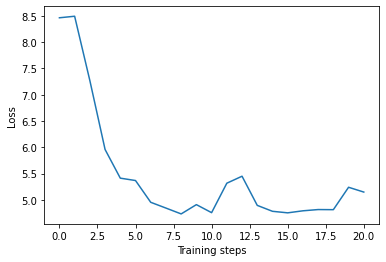

In [35]:
# One plot training and test loss.
plt.figure()
line1, = plt.plot(train_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

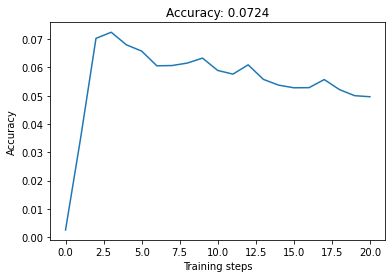

In [36]:
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.title("Accuracy: " + str(np.round(np.max(train_accuracies),4)))
plt.show()